In [40]:
import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgba
import warnings
from IPython.display import HTML

# --- Basic Setup ---
warnings.filterwarnings("ignore")
# Check for available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 1. Define Data Distributions ---
# Initial distribution p₀ (a single Gaussian)
p0_mean = torch.tensor([-5.0, 0.0], device=device)
p0_cov = torch.tensor([[0.1, 0.0], [0.0, 1.2]], device=device)

# Target distribution p₁ (a mixture of two Gaussians)
p1_means = [
    torch.tensor([5.0, 3.0], device=device),
    torch.tensor([5.0, -3.0], device=device)
]
p1_covs = [
    torch.tensor([[0.1, 0.0], [0.0, 0.5]], device=device),
    torch.tensor([[0.1, 0.0], [0.0, 0.5]], device=device)
]
p1_weights = torch.tensor([0.5, 0.5], device=device)


def sample_p0(n_samples):
    """Sample from the initial distribution p₀."""
    dist = torch.distributions.MultivariateNormal(p0_mean, p0_cov)
    return dist.sample((n_samples,))

def sample_p1(n_samples):
    """Sample from the target mixture distribution p₁."""
    indices = torch.multinomial(p1_weights, n_samples, replacement=True)
    samples = torch.zeros(n_samples, 2, device=device)
    for i, (mean, cov) in enumerate(zip(p1_means, p1_covs)):
        mask = indices == i
        n_choice = mask.sum()
        if n_choice > 0:
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples[mask] = dist.sample((n_choice,))
    return samples

# --- 2. Define the Neural Network Model ---

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.ff(x))

class VectorFieldNet(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t
        x = self.blocks(x)
        x = self.out_projection(x)
        return x


# --- 3. Train the Model ---

def train_flow_matching(model, epochs=5000, batch_size=2048, lr=1e-4):
    """Train the Flow Matching model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    print("Starting training...")

    for epoch in range(epochs):
        optimizer.zero_grad()

        x0 = sample_p0(batch_size)
        x1 = sample_p1(batch_size)
        t = torch.rand(batch_size, device=device)

        x_t = (1 - t.unsqueeze(1)) * x0 + t.unsqueeze(1) * x1
        u_t = x1 - x0

        v_pred = model(x_t, t)

        loss = loss_fn(v_pred, u_t)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    print("Training finished!")
    return model

# --- 4. ODE Solver (Heun's Method) ---

def solve_ode_heun(model, x0, num_steps):
    """Solve the ODE dx/dt = v(x,t) using Heun's method."""
    model.eval()
    trajectory = [x0.clone()]
    x = x0.clone()
    dt = 1.0 / num_steps

    with torch.no_grad():
        for i in range(num_steps):
            t = torch.full((x.size(0),), i * dt, device=device)
            v_pred = model(x, t)
            x_tilde = x + dt * v_pred
            t_next = torch.full((x.size(0),), (i + 1) * dt, device=device)
            v_tilde = model(x_tilde, t_next)
            x = x + 0.5 * dt * (v_pred + v_tilde)
            trajectory.append(x.clone())

    return torch.stack(trajectory).cpu().numpy()

# --- 5. Visualization Functions ---

def plot_training_pairs(ax, n_samples):
    """
    Plots the first subplot showing the random pairing of x0 and x1 during training.
    """
    color_p0 = '#5681EB'
    color_p1 = '#DD6772'

    # Set subplot appearance
    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    # For pairing, the number of samples for x0 and x1 must be the same
    x0_samples = sample_p0(n_samples).cpu().numpy()
    x1_samples = sample_p1(n_samples).cpu().numpy()

    # Plot scatter distributions for p0 and p1
    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label=r'Target Dist. ($\mathbf{x_1}\sim\mathbf{p_1}$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label=r'Initial Dist. ($\mathbf{x_0}\sim\mathbf{p_0}$)')

    # Prepare lines connecting each x0 to its corresponding x1, colored like x0
    lines = np.array(list(zip(x0_samples, x1_samples)))
    lc = LineCollection(lines, colors=color_p0, linewidths=1.0, alpha=0.4)
    ax.add_collection(lc)

    # Set title and legend
    ax.set_title('Training Pairings', fontsize=32, fontweight='bold')
    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def create_subplot(ax, trajectories, x0_samples, x1_samples, num_steps):
    """
    Draws a single subplot for the sampling process.
    """
    color_p0 = '#5681EB'
    color_x0 = '#5681EB'
    color_p1 = '#DD6772'
    color_x1 = '#B1D2BB'

    # Set background to white and remove grid
    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    # Plot target and initial distributions
    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label='Target Dist. ($\mathbf{x_1}\sim\mathbf{p_1}$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label='Initial Dist. ($\mathbf{x_0}\sim\mathbf{p_0}$)')

    # Prepare for drawing trajectories
    lines = []
    colors = []
    start_rgba = np.array(to_rgba(color_x0))
    end_rgba = np.array(to_rgba(color_x1))
    for i in range(trajectories.shape[1]):
        points = trajectories[:, i, :]
        segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
        lines.extend(segments)
        t_fractions = np.linspace(0, 1, num_steps)
        segment_colors = (1 - t_fractions[:, np.newaxis]) * start_rgba + t_fractions[:, np.newaxis] * end_rgba
        colors.extend(segment_colors)

    lc = LineCollection(lines, colors=colors, linewidths=1.5, alpha=0.7)
    ax.add_collection(lc)

    # Set title to emphasize the number of sampling steps
    ax.set_title(f'Sampling: {num_steps} Steps', fontsize=32, fontweight='bold')

    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def visualize_trajectories(model, n_samples=300):
    """
    Creates a figure with three subplots, organized according to the new requirements.
    """
    # Set the sampling steps to plot to 1 and 5
    steps_to_plot = [1, 5]
    fig, axes = plt.subplots(1, 3, figsize=(28, 9))
    fig.patch.set_facecolor('white')

    # --- Subplot 1: Show training pairs ---
    plot_training_pairs(axes[0], n_samples)

    # --- Subplots 2 & 3: Show sampling process ---
    x0_samples_ode = sample_p0(n_samples).cpu().numpy()
    x1_samples_display = sample_p1(n_samples * 2).cpu().numpy()
    x0_tensor = torch.tensor(x0_samples_ode, device=device)

    # Iterate to plot subplots for sampling steps 1 and 5
    for ax, num_steps in zip(axes[1:], steps_to_plot):
        trajectories = solve_ode_heun(model, x0_tensor, num_steps)
        create_subplot(ax, trajectories, x0_samples_ode, x1_samples_display, num_steps)

    plt.tight_layout()
    plt.show()

def animate_two_stage_flow(model, n_samples=300, num_flow_frames=120):
    """
    Creates a two-stage animation with a trail-drawing implementation.

    Phase 1: Arrows travel along trajectories, drawing efficient trails.
    Phase 2: Samples travel along the same trajectories.

    Args:
        model (nn.Module): The trained Flow Matching model.
        n_samples (int): The number of sample points to animate.
        num_flow_frames (int): The number of frames for a single flow.
    """
    print("Generating two-stage animation with trails...")

    # --- 1. Pre-computation Phase (Unchanged) ---
    x0_samples_torch = sample_p0(n_samples)
    x0_samples_np = x0_samples_torch.cpu().numpy()
    x1_samples_display = sample_p1(n_samples * 2).cpu().numpy()
    trajectories = solve_ode_heun(model, x0_samples_torch, num_steps=num_flow_frames - 1)
    velocities = np.zeros_like(trajectories)
    model.eval()
    with torch.no_grad():
        for i in range(num_flow_frames):
            t = torch.full((n_samples,), i / (num_flow_frames - 1), device=device)
            positions_torch = torch.from_numpy(trajectories[i]).to(device)
            velocities[i] = model(positions_torch, t).cpu().numpy()

    # --- 2. Matplotlib Animation Setup ---
    total_animation_frames = 2 * num_flow_frames
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    color_p0 = '#5681EB'
    color_trail = '#B1D2BB'
    color_p1_bg = '#DD6772'
    color_arrow = '#E03516'

    def update(frame):
        ax.clear()
        ax.set_facecolor('white')
        ax.grid(False)
        ax.axis('off')
        ax.set_xlim(-8, 8)
        ax.set_ylim(-7, 7)
        ax.set_aspect('equal', adjustable='box')
        ax.scatter(x1_samples_display[:, 0], x1_samples_display[:, 1],
                   color=color_p1_bg, alpha=0.1, s=60)

        if frame < num_flow_frames:
            # --- PHASE 1: ARROWS MOVE WITH TRAILS ---
            flow_idx = frame
            ax.scatter(x0_samples_np[:, 0], x0_samples_np[:, 1],
                       color=color_p0, alpha=0.5, s=60)

            # 【CORRECTION】Optimized trail drawing using vectorized NumPy
            if flow_idx > 0:
                paths_so_far = trajectories[0:flow_idx + 1]

                # Prepare segments in a highly efficient, vectorized manner
                points_start = paths_so_far[:-1] # Shape: (flow_idx, n_samples, 2)
                points_end = paths_so_far[1:]   # Shape: (flow_idx, n_samples, 2)

                # Reshape for LineCollection which expects (num_segments, 2, 2)
                segments = np.stack((points_start, points_end), axis=2)
                segments = segments.transpose(1, 0, 2, 3).reshape(-1, 2, 2)

                trail_collection = LineCollection(segments, colors=color_trail, linewidths=1.5, alpha=0.4)
                ax.add_collection(trail_collection)

            # Arrows move at the tip of the trail
            current_positions = trajectories[flow_idx]
            current_velocities = velocities[flow_idx]
            scale_factor = 40
            ax.quiver(current_positions[:, 0], current_positions[:, 1],
                      current_velocities[:, 0], current_velocities[:, 1],
                      color=color_arrow, angles='xy', scale_units='xy', scale=scale_factor,
                      headwidth=4, headlength=5, width=0.005)

            current_time = flow_idx / (num_flow_frames - 1)
            ax.set_title(f'Vector Field Flow\nTime $t={current_time:.2f}$',
                         fontsize=20, fontweight='bold')

        else:
            # --- PHASE 2: SAMPLES FOLLOW (Logic is correct and now reachable) ---
            flow_idx = frame - num_flow_frames
            current_positions = trajectories[flow_idx]
            ax.scatter(current_positions[:, 0], current_positions[:, 1],
                       color=color_p0, alpha=0.8, s=60)

            current_time = flow_idx / (num_flow_frames - 1)
            ax.set_title(f'Sample Points Flow\nTime $t={current_time:.2f}$',
                         fontsize=20, fontweight='bold')

    # --- 3. Create and return the animation object ---
    anim = FuncAnimation(fig, update, frames=total_animation_frames, interval=50, blit=False)

    print("Two-stage animation generated.")
    return anim

def animate_flow_matching_with_pairing(model, n_samples=100, num_flow_frames=120):
    """
    Creates a three-stage animation.

    Phase 1: Dynamically shows the random pairing between p0 and p1 samples.
    Phase 2: Arrows travel along trajectories, drawing trails.
    Phase 3: Samples travel along the same trajectories.

    Args:
        model (nn.Module): The trained Flow Matching model.
        n_samples (int): The number of sample points to animate.
        num_flow_frames (int): The number of frames for a single flow (phases 2 & 3).
    """
    print("Generating three-stage animation with pairing visualization...")

    # --- 1. Pre-computation Phase ---
    # Sample data points for all phases
    x0_samples_torch = sample_p0(n_samples)
    x0_samples_np = x0_samples_torch.cpu().numpy()
    x1_samples_np = sample_p1(n_samples).cpu().numpy()
    x1_samples_display = sample_p1(n_samples * 2).cpu().numpy() # For background display

    # Pre-compute trajectories and velocities for the flow part (Phases 2 & 3)
    trajectories = solve_ode_heun(model, x0_samples_torch, num_steps=num_flow_frames - 1)
    velocities = np.zeros_like(trajectories)
    model.eval()
    with torch.no_grad():
        for i in range(num_flow_frames):
            t = torch.full((n_samples,), i / (num_flow_frames - 1), device=device)
            positions_torch = torch.from_numpy(trajectories[i]).to(device)
            velocities[i] = model(positions_torch, t).cpu().numpy()

    # --- 2. Animation Setup ---
    # Define frame counts for each phase
    n_pairing_rounds = 2
    pairing_frames_per_round = n_samples
    total_pairing_frames = n_pairing_rounds * pairing_frames_per_round
    total_flow_frames = 2 * num_flow_frames
    total_animation_frames = total_pairing_frames + total_flow_frames

    # Pre-generate random pairings for reproducibility within the animation
    pairing_indices = [np.random.permutation(n_samples) for _ in range(n_pairing_rounds)]

    # --- 3. Matplotlib Figure Setup ---
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    color_p0 = '#5681EB'
    color_p1 = '#DD6772'
    color_line = '#666666'
    color_trail = '#B1D2BB'
    color_arrow = '#E03516'

    def update(frame):
        ax.clear()
        ax.set_facecolor('white')
        ax.grid(False)
        ax.axis('off')
        ax.set_xlim(-8, 8)
        ax.set_ylim(-7, 7)
        ax.set_aspect('equal', adjustable='box')

        # --- STAGE 1: PAIRING ANIMATION ---
        if frame < total_pairing_frames:
            round_num = frame // pairing_frames_per_round
            line_idx_in_round = frame % pairing_frames_per_round

            ax.set_title(f'Training Pairings (Epoch {round_num + 1}/{n_pairing_rounds})',
                         fontsize=20, fontweight='bold')

            # Draw the base distributions
            ax.scatter(x1_samples_np[:, 0], x1_samples_np[:, 1],
                       color=color_p1, alpha=0.3, s=60)
            ax.scatter(x0_samples_np[:, 0], x0_samples_np[:, 1],
                       color=color_p0, alpha=0.8, s=60)

            # Collect all lines that should be drawn in this frame
            lines_to_draw = []
            # Draw all lines from previous full rounds
            for r in range(round_num):
                indices = pairing_indices[r]
                round_lines = np.stack((x0_samples_np[indices], x1_samples_np), axis=1)
                lines_to_draw.extend(list(round_lines))

            # Draw lines for the current, partially completed round
            current_round_indices = pairing_indices[round_num]
            current_round_lines = np.stack((x0_samples_np[current_round_indices[:line_idx_in_round+1]],
                                            x1_samples_np[:line_idx_in_round+1]), axis=1)
            lines_to_draw.extend(list(current_round_lines))

            if lines_to_draw:
                lc = LineCollection(lines_to_draw, colors=color_line, linewidths=0.8, alpha=0.5)
                ax.add_collection(lc)

        # --- STAGES 2 & 3: FLOW ANIMATION ---
        else:
            flow_frame = frame - total_pairing_frames
            # Background target distribution for context
            ax.scatter(x1_samples_display[:, 0], x1_samples_display[:, 1],
                       color=color_p1, alpha=0.1, s=60)

            # --- STAGE 2: VECTOR FIELD FLOW ---
            if flow_frame < num_flow_frames:
                flow_idx = flow_frame
                ax.scatter(x0_samples_np[:, 0], x0_samples_np[:, 1],
                           color=color_p0, alpha=0.5, s=60)

                # Draw trails efficiently
                if flow_idx > 0:
                    paths_so_far = trajectories[0:flow_idx + 1]
                    points_start = paths_so_far[:-1]
                    points_end = paths_so_far[1:]
                    segments = np.stack((points_start, points_end), axis=2)
                    segments = segments.transpose(1, 0, 2, 3).reshape(-1, 2, 2)
                    trail_collection = LineCollection(segments, colors=color_trail, linewidths=1.5, alpha=0.4)
                    ax.add_collection(trail_collection)

                # Draw moving arrows
                current_positions = trajectories[flow_idx]
                current_velocities = velocities[flow_idx]
                scale_factor = 40
                ax.quiver(current_positions[:, 0], current_positions[:, 1],
                          current_velocities[:, 0], current_velocities[:, 1],
                          color=color_arrow, angles='xy', scale_units='xy', scale=scale_factor,
                          headwidth=4, headlength=5, width=0.005)

                current_time = flow_idx / (num_flow_frames - 1)
                ax.set_title(f'Vector Field Flow\nTime $t={current_time:.2f}$',
                             fontsize=20, fontweight='bold')

            # --- STAGE 3: SAMPLE POINTS FLOW ---
            else:
                flow_idx = flow_frame - num_flow_frames
                current_positions = trajectories[flow_idx]
                ax.scatter(current_positions[:, 0], current_positions[:, 1],
                           color=color_p0, alpha=0.8, s=60)

                current_time = flow_idx / (num_flow_frames - 1)
                ax.set_title(f'Sample Points Flow\nTime $t={current_time:.2f}$',
                             fontsize=20, fontweight='bold')


    # --- 4. Create and return the animation object ---
    # Use a small interval for faster animation, especially the pairing part
    anim = FuncAnimation(fig, update, frames=total_animation_frames, interval=50, blit=False)
    plt.close(fig) # Prevent static plot from showing in notebooks

    print("Three-stage animation generated successfully!")
    return anim


Using device: cuda


Starting training...
Epoch [500/10000], Loss: 2.398433
Epoch [1000/10000], Loss: 2.268754
Epoch [1500/10000], Loss: 2.331502
Epoch [2000/10000], Loss: 2.509590
Epoch [2500/10000], Loss: 2.437307
Epoch [3000/10000], Loss: 2.436871
Epoch [3500/10000], Loss: 2.308543
Epoch [4000/10000], Loss: 2.363540
Epoch [4500/10000], Loss: 2.403477
Epoch [5000/10000], Loss: 2.325220
Epoch [5500/10000], Loss: 2.375711
Epoch [6000/10000], Loss: 2.351317
Epoch [6500/10000], Loss: 2.453372
Epoch [7000/10000], Loss: 2.329359
Epoch [7500/10000], Loss: 2.394794
Epoch [8000/10000], Loss: 2.429504
Epoch [8500/10000], Loss: 2.466239
Epoch [9000/10000], Loss: 2.325012
Epoch [9500/10000], Loss: 2.225942
Epoch [10000/10000], Loss: 2.425074
Training finished!


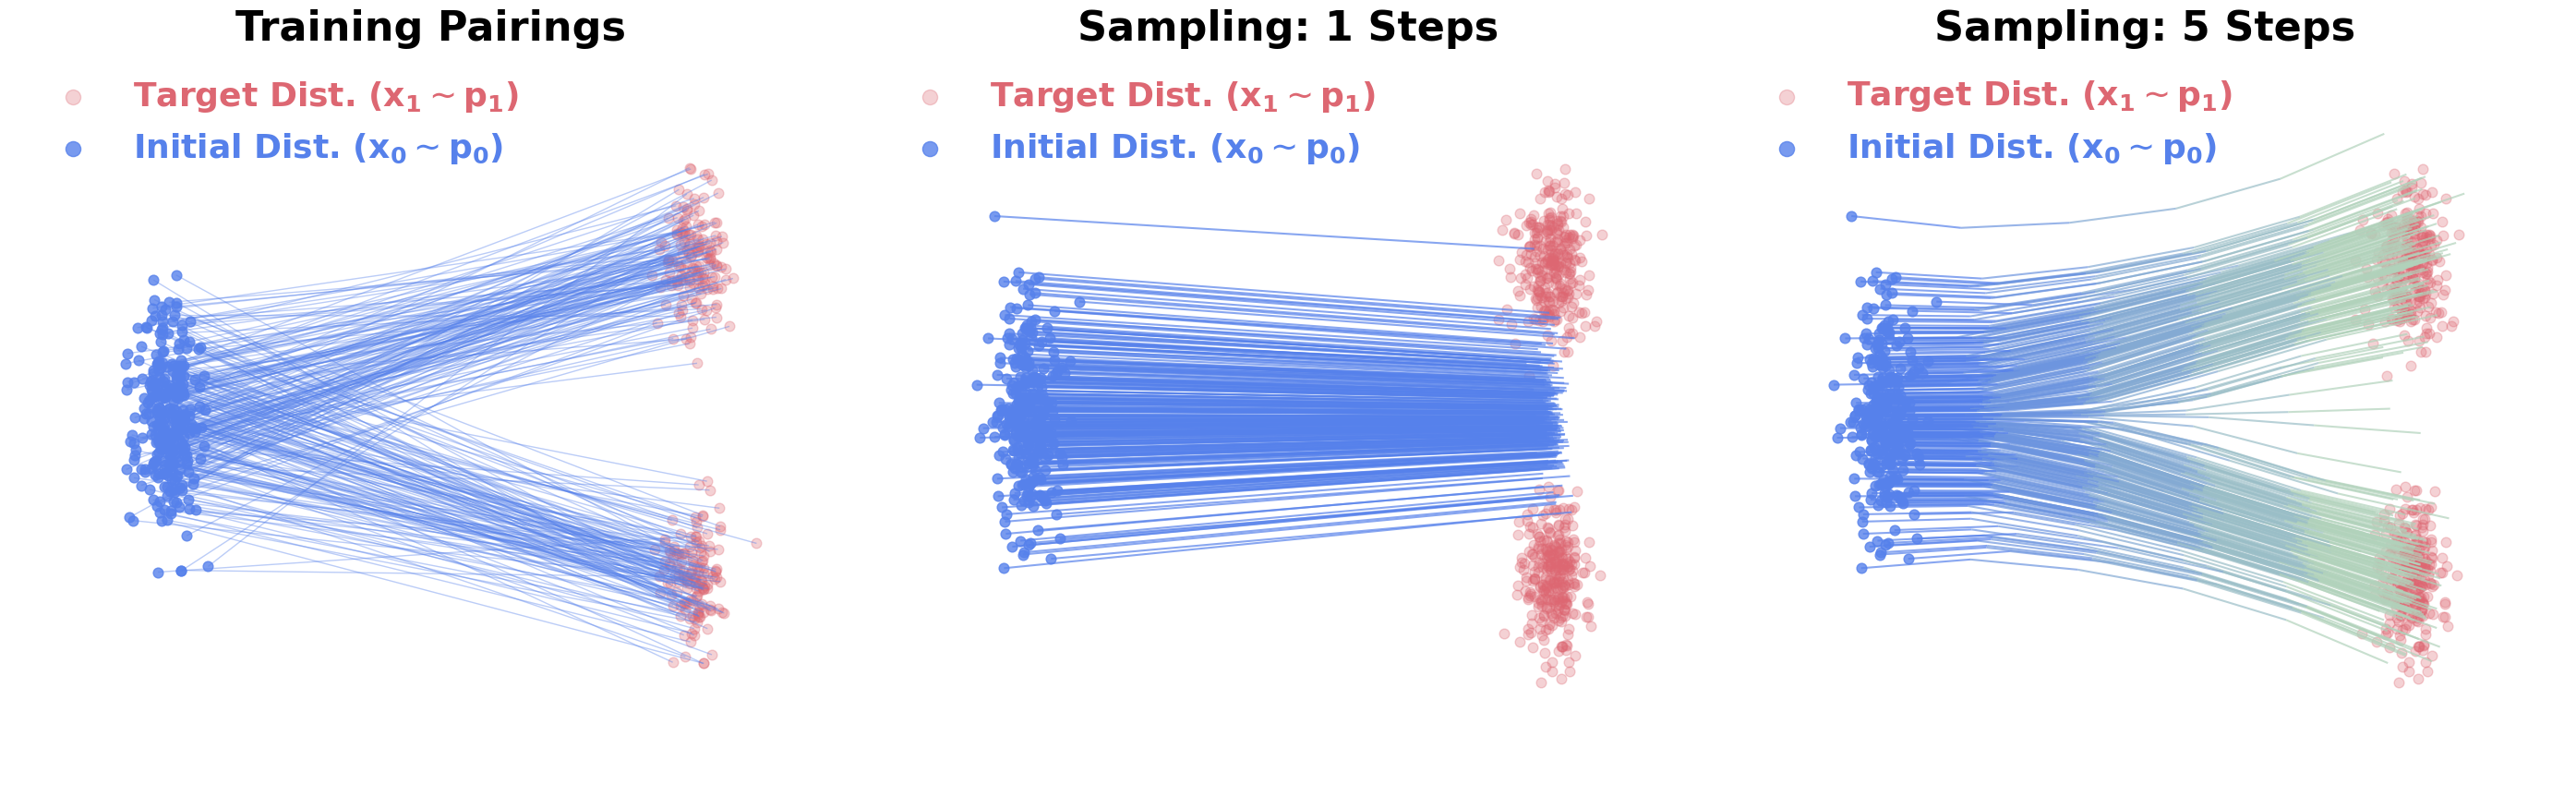

In [41]:
model = VectorFieldNet().to(device)
train_flow_matching(model, epochs=10000)
visualize_trajectories(model, n_samples=300)

In [ ]:
plt.rcParams['animation.embed_limit'] = 50
two_stage_animation = animate_two_stage_flow(model, n_samples=300, num_flow_frames=60)
two_stage_animation.save('flow_matching_animate_two_stage_flow.gif', writer='pillow', fps=20)
display(HTML(two_stage_animation.to_jshtml()))

In [ ]:
plt.rcParams['animation.embed_limit'] = 50
animation = animate_flow_matching_with_pairing(model, n_samples=100, num_flow_frames=60)
animation.save('flow_matching_animate_flow_matching_with_pairing.gif', writer='pillow', fps=20)
display(HTML(animation.to_jshtml()))